In [5]:
#Librerías principales
import os, sys
import pandas as pd
import numpy as np
import joblib

#Librerías de ML
from sentence_transformers import SentenceTransformer
from sklearn.metrics import f1_score, classification_report

#Ajustar path para importar desde src (subir un nivel desde notebooks/)
sys.path.append(os.path.abspath(os.path.join("..", "src")))

#Módulos propios
from data_loader import cargar_dataset, dividir_dataset
from preprocessing import preparar_texto, preparar_labels
from train import baseline_train
from evaluate import evaluar_modelo
from utils import semilla

#Configuración de semilla
semilla(42)


In [6]:
#Cargar dataset ya preprocesado
df = pd.read_csv("../data/dataset_prepared.csv")

#Dividir en train, validación y test
train_df, val_df, test_df = dividir_dataset(df, test_size=0.2, val_size=0.1, random_state=42)

In [7]:
#Textos como listas
X_train_text = preparar_texto(train_df).to_list()
X_val_text   = preparar_texto(val_df).to_list()
X_test_text  = preparar_texto(test_df).to_list()

#Etiquetas multilabel
y_train, mlb = preparar_labels(train_df)
y_val  = mlb.transform(val_df["group"].astype(str).apply(lambda x: x.split("|")))
y_test = mlb.transform(test_df["group"].astype(str).apply(lambda x: x.split("|")))

In [8]:
#Cargar modelo pre-entrenado
embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

#Embeddings (vectores densos)
X_train = embedder.encode(X_train_text, convert_to_numpy=True, show_progress_bar=True, batch_size=64)
X_val   = embedder.encode(X_val_text,   convert_to_numpy=True, show_progress_bar=True, batch_size=64)
X_test  = embedder.encode(X_test_text,  convert_to_numpy=True, show_progress_bar=True, batch_size=64)

#Revisar dimensiones
X_train.shape, X_val.shape, X_test.shape

No sentence-transformers model found with name sentence-transformers/all-MiniLM-L6-v2. Creating a new one with mean pooling.
c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kevin\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-you

((2566, 384), (286, 384), (713, 384))

In [9]:
# Entrenar modelo clásico (Logistic Regression OneVsRest)
modelo_emb = baseline_train(X_train, y_train)

In [10]:
# Predicciones en validación
P_val = modelo_emb.predict_proba(X_val)

# Buscar umbrales por clase maximizando F1
ts = np.linspace(0.2, 0.8, 25)
best_t = []

for j in range(P_val.shape[1]):
    f1s = [f1_score(y_val[:, j], (P_val[:, j] >= t).astype(int)) for t in ts]
    best_t.append(ts[int(np.argmax(f1s))])

print("Mejores umbrales por clase:", best_t)

Mejores umbrales por clase: [0.35000000000000003, 0.4750000000000001, 0.5250000000000001, 0.32500000000000007]


In [11]:
# Predicciones en test con umbrales optimizados
P_test = modelo_emb.predict_proba(X_test)
y_pred_test = (P_test >= np.array(best_t)).astype(int)

# Garantizar al menos 1 etiqueta por muestra
rows_no_label = y_pred_test.sum(axis=1) == 0
y_pred_test[rows_no_label, np.argmax(P_test[rows_no_label], axis=1)] = 1

# Métricas
print("F1 micro:", f1_score(y_test, y_pred_test, average="micro"))
print("F1 macro:", f1_score(y_test, y_pred_test, average="macro"))
print(classification_report(y_test, y_pred_test, target_names=mlb.classes_))

F1 micro: 0.8588110403397028
F1 macro: 0.8565974350563343
                precision    recall  f1-score   support

cardiovascular       0.82      0.90      0.86       254
   hepatorenal       0.90      0.82      0.86       217
  neurological       0.89      0.84      0.86       358
   oncological       0.84      0.85      0.85       120

     micro avg       0.87      0.85      0.86       949
     macro avg       0.86      0.85      0.86       949
  weighted avg       0.87      0.85      0.86       949
   samples avg       0.90      0.90      0.88       949




--- Resultados embeddings (val) ---
Exact Match Ratio: 0.7028
F1 Micro: 0.8575
F1 Macro: 0.8477

Classification Report:

                precision    recall  f1-score   support

cardiovascular       0.94      0.82      0.88       102
   hepatorenal       0.84      0.79      0.82        87
  neurological       0.90      0.86      0.88       142
   oncological       0.92      0.73      0.81        48

     micro avg       0.90      0.82      0.86       379
     macro avg       0.90      0.80      0.85       379
  weighted avg       0.90      0.82      0.86       379
   samples avg       0.91      0.87      0.87       379



c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


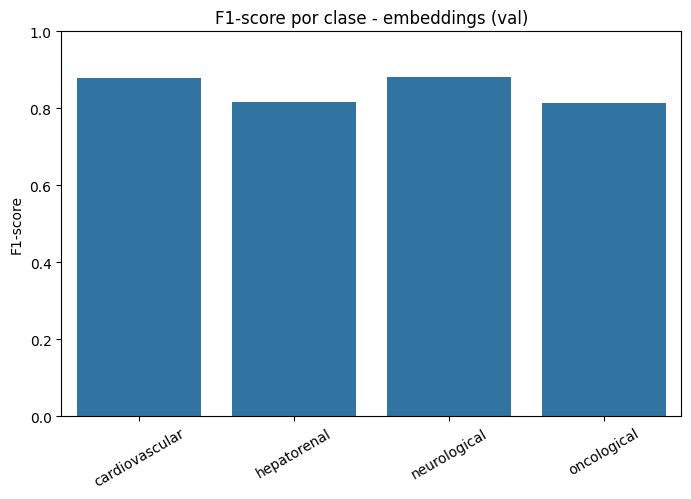

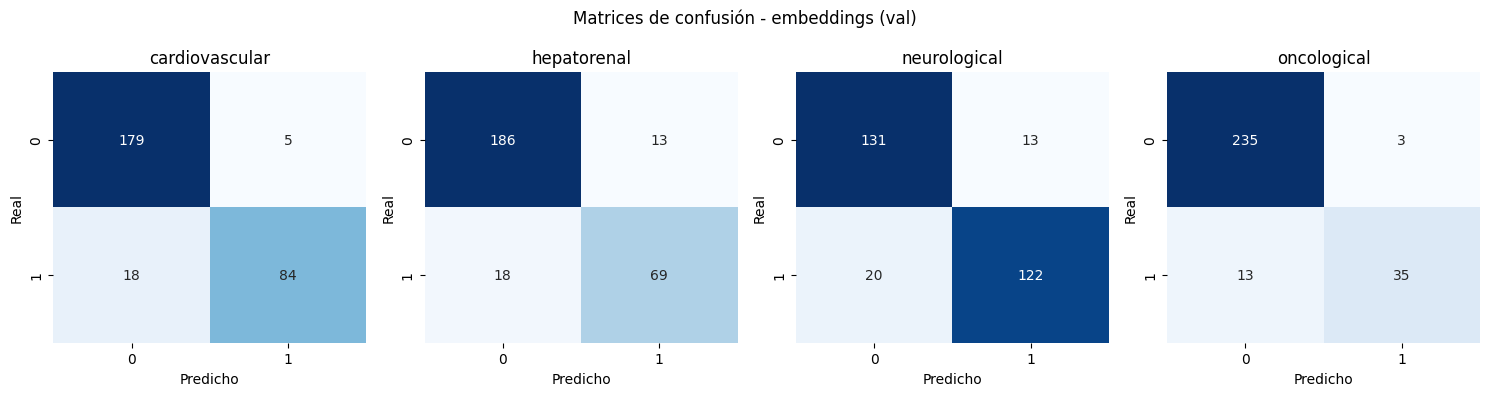

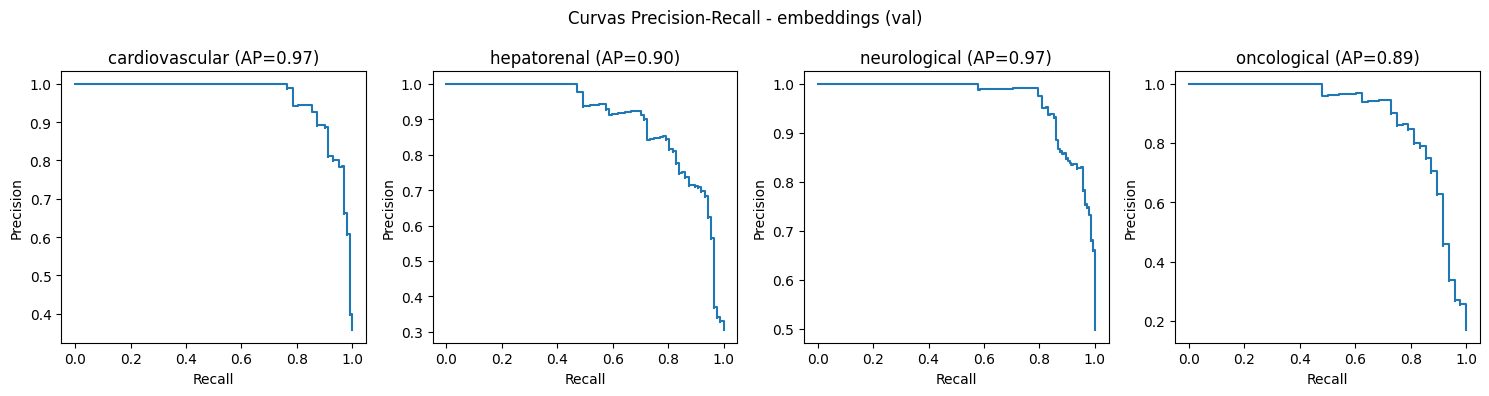

c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



--- Resultados embeddings (test) ---
Exact Match Ratio: 0.6760
F1 Micro: 0.8527
F1 Macro: 0.8471

Classification Report:

                precision    recall  f1-score   support

cardiovascular       0.86      0.83      0.85       254
   hepatorenal       0.90      0.82      0.86       217
  neurological       0.89      0.84      0.87       358
   oncological       0.95      0.72      0.82       120

     micro avg       0.89      0.82      0.85       949
     macro avg       0.90      0.80      0.85       949
  weighted avg       0.89      0.82      0.85       949
   samples avg       0.91      0.87      0.87       949



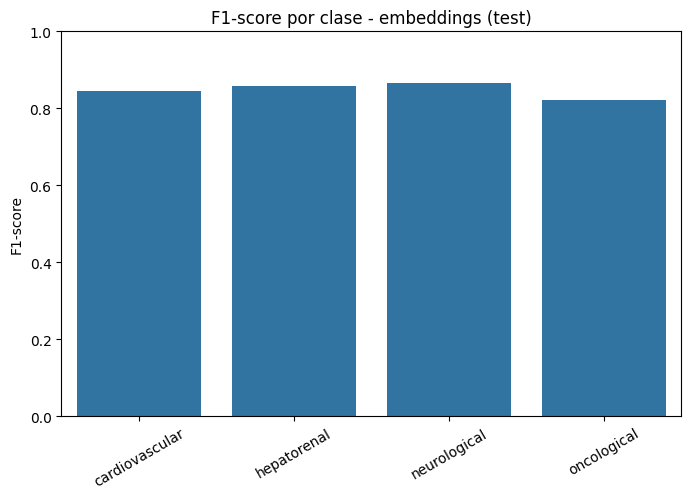

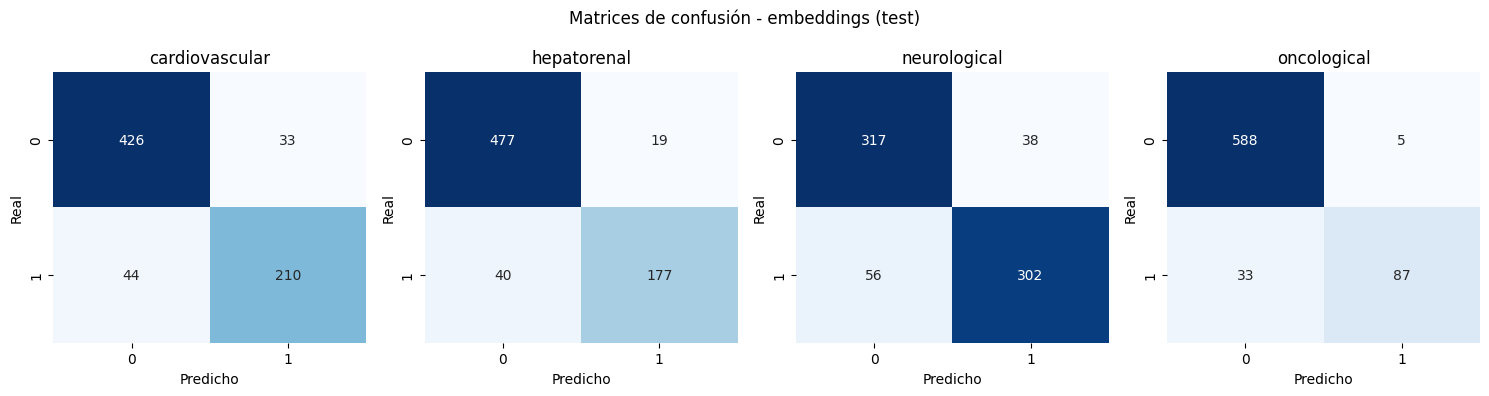

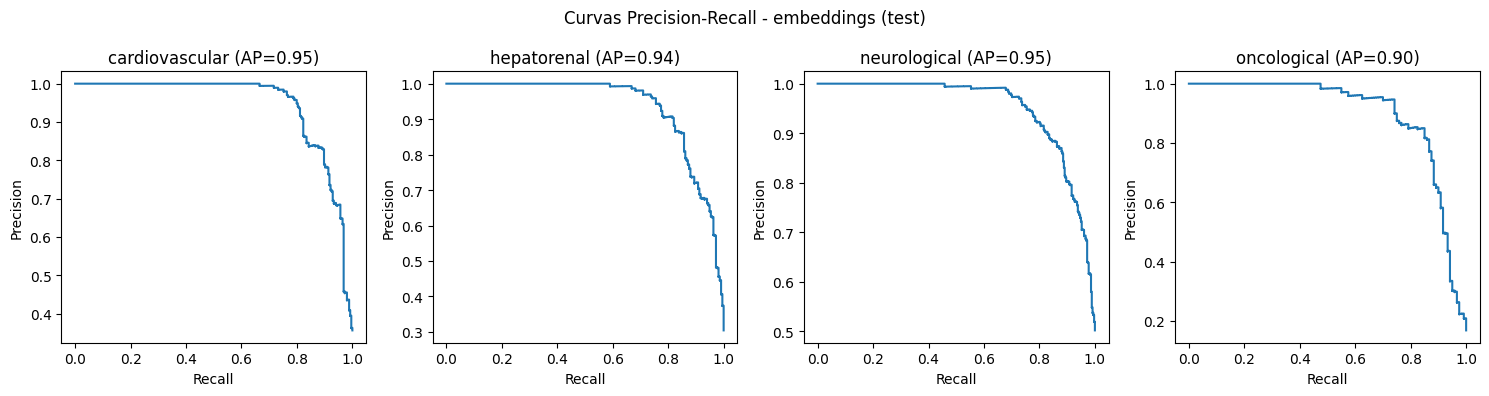

In [12]:
# Evaluar en validación y test usando nuestra función
_ = evaluar_modelo(modelo_emb, X_val, y_val, mlb,
                   nombre_modelo="embeddings",
                   split="val",
                   show_plots=True,
                   save_path="../evidence/embeddings_val")

_ = evaluar_modelo(modelo_emb, X_test, y_test, mlb,
                   nombre_modelo="embeddings",
                   split="test",
                   show_plots=True,
                   save_path="../evidence/embeddings_test")


In [13]:
# Guardar modelo, vectorizador y binarizador
joblib.dump(modelo_emb, "../models/embeddings_logreg.joblib")
joblib.dump(embedder, "../models/sentence_transformer.joblib")
joblib.dump(mlb, "../models/labels_mlb_embeddings.joblib")

['../models/labels_mlb_embeddings.joblib']

In [14]:
####opcional





#

c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



--- Resultados embeddings (val) ---
Exact Match Ratio: 0.7028
F1 Micro: 0.8575
F1 Macro: 0.8477

Classification Report:

                precision    recall  f1-score   support

cardiovascular       0.94      0.82      0.88       102
   hepatorenal       0.84      0.79      0.82        87
  neurological       0.90      0.86      0.88       142
   oncological       0.92      0.73      0.81        48

     micro avg       0.90      0.82      0.86       379
     macro avg       0.90      0.80      0.85       379
  weighted avg       0.90      0.82      0.86       379
   samples avg       0.91      0.87      0.87       379



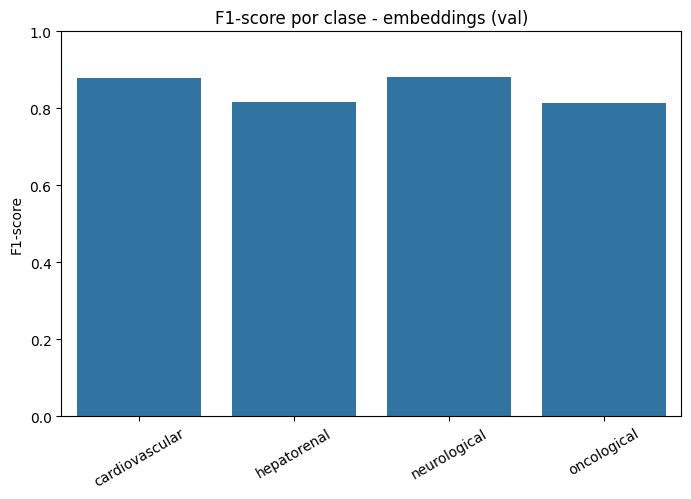

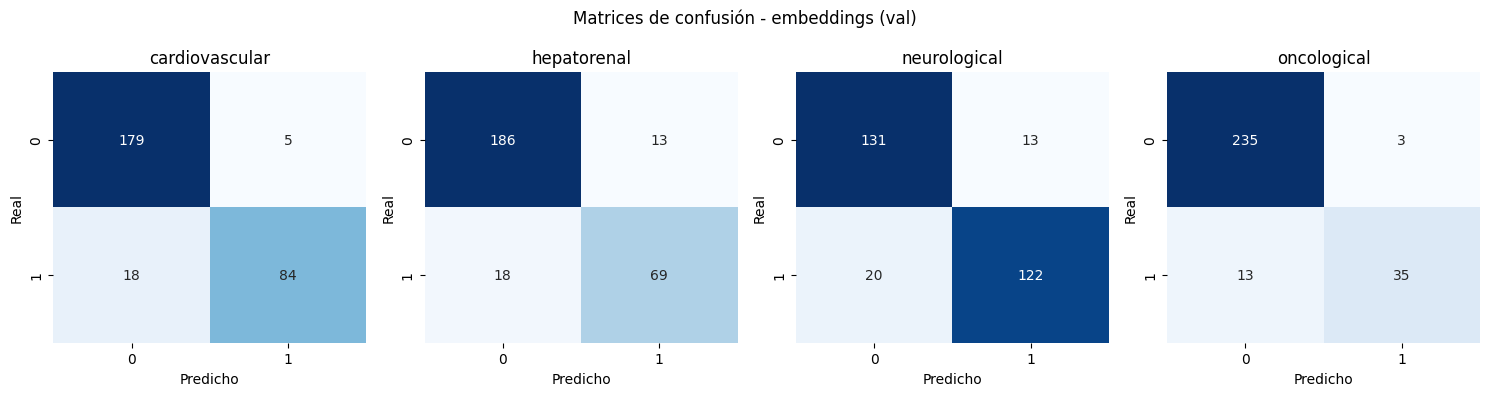

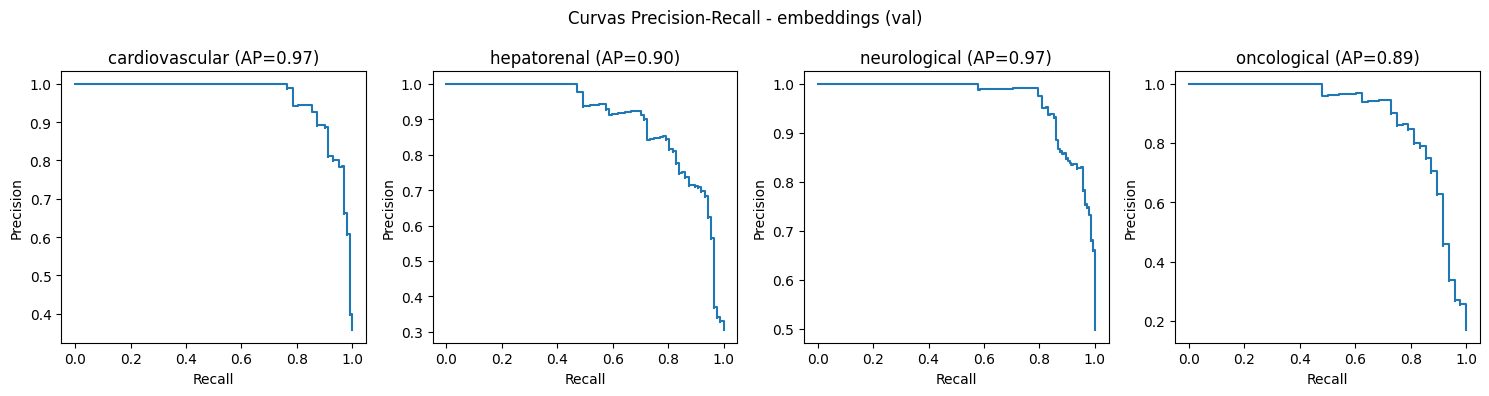

c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



--- Resultados embeddings (test) ---
Exact Match Ratio: 0.6760
F1 Micro: 0.8527
F1 Macro: 0.8471

Classification Report:

                precision    recall  f1-score   support

cardiovascular       0.86      0.83      0.85       254
   hepatorenal       0.90      0.82      0.86       217
  neurological       0.89      0.84      0.87       358
   oncological       0.95      0.72      0.82       120

     micro avg       0.89      0.82      0.85       949
     macro avg       0.90      0.80      0.85       949
  weighted avg       0.89      0.82      0.85       949
   samples avg       0.91      0.87      0.87       949



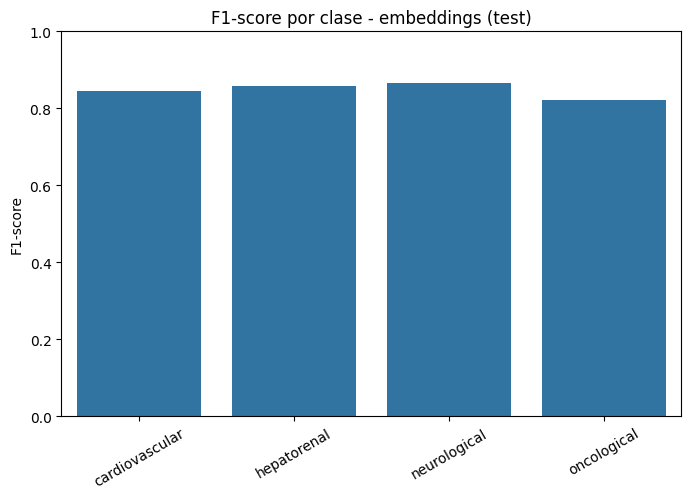

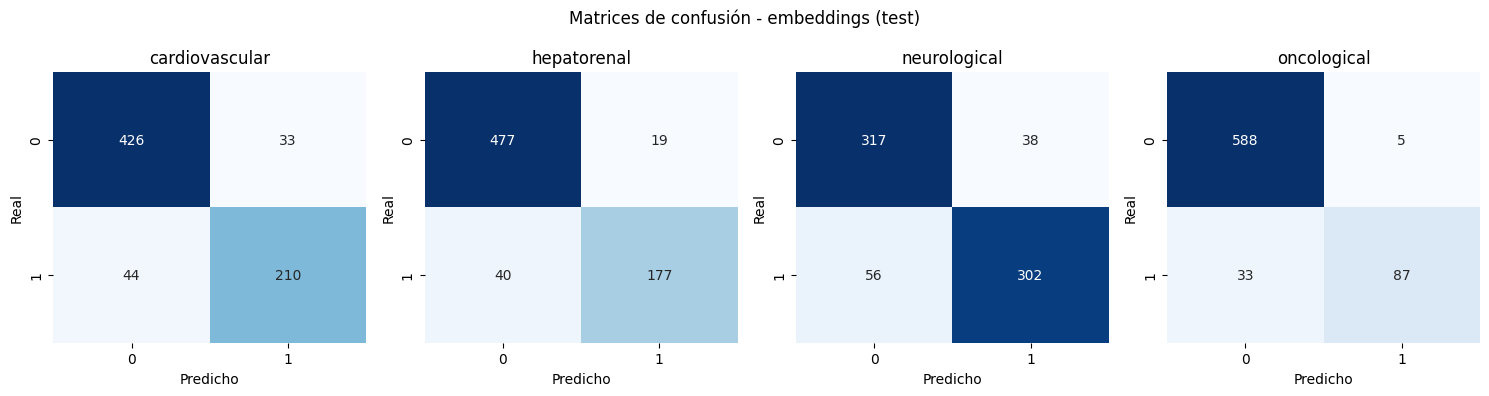

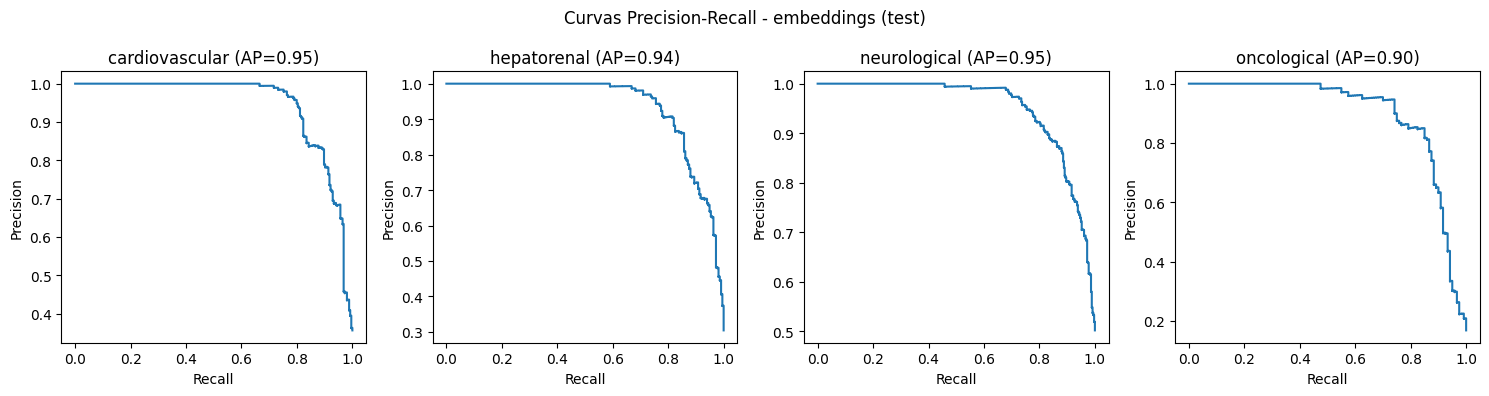

In [15]:
#evaluar
metrics_val = evaluar_modelo(
    modelo_emb,
    X_val,
    y_val,
    mlb,
    nombre_modelo="embeddings",
    split="val",
    show_plots=True,
    save_path="../evidence/embeddings_val"
)

metrics_test = evaluar_modelo(
    modelo_emb,
    X_test,
    y_test,
    mlb,
    nombre_modelo="embeddings",
    split="test",
    show_plots=True,
    save_path="../evidence/embeddings_test"
)


In [16]:
#GUARDAR
joblib.dump(modelo_emb, "../models/embeddings_logreg.joblib")
joblib.dump(embedder, "../models/sentence_transformer.joblib")
joblib.dump(mlb, "../models/labels_mlb_embeddings.joblib")

['../models/labels_mlb_embeddings.joblib']